# Project 3


# Conversations Toxicity Detection

Jigsaw Unintended Bias in Toxicity Classification 

Detect toxicity across a diverse range of conversations


https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data#

# Sample Solution

## Model with TF-IDF and Ranfom Forest

In [5]:
pip install joblib


The following command must be run outside of the IPython shell:

    $ pip install joblib

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
import string
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
stop_words = set(stopwords.words('english'))
stem = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to C:\Users\ENVY
[nltk_data]     M6\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ENVY
[nltk_data]     M6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
train_df = pd.read_csv("train.csv.zip")
train_df = train_df[['id','comment_text', 'target']]
test_df = pd.read_csv("test.csv.zip")

In [9]:
train_df.head()

,id,comment_text,target
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000
1,59849,Thank you!! This would make my life a lot less...,0.000000
2,59852,This is such an urgent design problem; kudos t...,0.000000
3,59855,Is this something I'll be able to install on m...,0.000000
4,59856,haha you guys are a bunch of losers.,0.893617


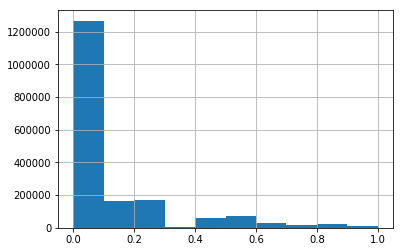

In [10]:
train_df.target.hist()

In [11]:
train_df.shape

(1804874, 3)

In [12]:
test_df.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [13]:
test_df.shape

(97320, 2)

In [14]:
train_df = train_df.sample(1000, random_state=42)
test_df = test_df.sample(1000, random_state=42)

In [15]:
train_df.shape

(1000, 3)

Delete numbers

In [16]:
train_df['comment_text'] = train_df['comment_text'].str.replace('\d+', '')

In [17]:
test_df['comment_text'] = test_df['comment_text'].str.replace('\d+', '')

Contractions

In [18]:
import re

In [19]:
contraction_patterns = [(r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'),\
                        (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'),\
                        (r'(\w+)n\'t', '\g<1> not'),\
                        (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'),\
                        (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'),\
                        (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'),\
                        (r'wont', 'will not')]

def replace_contraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

In [20]:
#train_df

In [21]:
train_df['comment_text'] = train_df['comment_text'].apply(replace_contraction)#replace_contraction(train_df['comment_text'])

In [22]:
#train_df

In [23]:
test_df['comment_text'] = test_df['comment_text'].apply(replace_contraction)

Replace negatives for antonyms

In [24]:
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

In [25]:
def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None

def replace_negations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
        word = text[i]
        if word == 'not' and i+1 < l:
            ant = replace(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue
        words.append(word)
        i += 1
    return words

def tokenize_and_replace_negations(text):
    tokens = nltk.word_tokenize(text)
    tokens = replace_negations(tokens)
    text = " ".join(tokens)
    return text

In [26]:
#train_df

In [27]:
train_df['comment_text'] = train_df['comment_text'].apply(tokenize_and_replace_negations)

In [28]:
#train_df

In [29]:
test_df['comment_text'] = test_df['comment_text'].apply(tokenize_and_replace_negations)

In [30]:
#test_df

Preprocess of punctuation and misspell(from the kernel https://www.kaggle.com/nikhilsharma00/clean-data-keras-embbedings-cudnn-predict)

In [31]:
def preprocess(data):
    '''
    Reference: https://www.kaggle.com/abhigupta4981/pytorch-train-with-callbacks
               and
               simple-eda-text-preprocessing-jigsaw
    '''
    print("pre-processing")
    punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^','\n'
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
    
    def clean_special_chars(text, punct):
        def get_misspell(text):
            
            contract = {"'SB91':'senate bill','tRump':'trump','utmterm':'utm term','FakeNews':'fake news','Gʀᴇat':'great','ʙᴏᴛtoᴍ':'bottom','washingtontimes':'washington times','garycrum':'gary crum','htmlutmterm':'html utm term','RangerMC':'car','TFWs':'tuition fee waiver','SJWs':'social justice warrior','Koncerned':'concerned','Vinis':'vinys','Yᴏᴜ':'you','Trumpsters':'trump','Trumpian':'trump','bigly':'big league','Trumpism':'trump','Yoyou':'you','Auwe':'wonder','Drumpf':'trump','utmterm':'utm term','Brexit':'british exit','utilitas':'utilities','ᴀ':'a', '😉':'wink','😂':'joy','😀':'stuck out tongue', 'theguardian':'the guardian','deplorables':'deplorable', 'theglobeandmail':'the globe and mail', 'justiciaries': 'justiciary','creditdation': 'Accreditation','doctrne':'doctrine','fentayal': 'fentanyl','designation-': 'designation','CONartist' : 'con-artist','Mutilitated' : 'Mutilated','Obumblers': 'bumblers','negotiatiations': 'negotiations','dood-': 'dood','irakis' : 'iraki','cooerate': 'cooperate','COx':'cox','racistcomments':'racist comments','envirnmetalists': 'environmentalists',Trump's" : 'trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have','can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }
            for word in text.split():
                if word.lower() in contract:
                    text = text.replace(word, contract[word.lower()])
                    
            return text
        text=get_misspell(text)    
        for p in (punct):
            text = text.replace(p,' ')
        return text
    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    
    return data

In [32]:
train_df_2=train_df
test_df_2=test_df

In [33]:
#train_df_2

In [34]:
# Pre-proccesing train data
train_df['comment_text']=preprocess(train_df['comment_text'].astype(str))
test_df['comment_text']=preprocess(test_df['comment_text'].astype(str))

pre-processing
pre-processing


In [35]:
#train_df#=pd.DataFrame(train_df)

In [36]:
#test_df#=pd.DataFrame(test_df)

In [37]:
train_df.head()

,id,comment_text,target
286892,593336,What a breathe of fresh air to have someone wh...,0.166667
419218,756192,Your jewish friends were the ones who told you...,0.600000
1055330,5407051,Possible collusion by Trump and his affiliates...,0.000000
1382764,5808132,Exactly We need a of GDP spending cap at t...,0.000000
256049,557013,By your own comment even if some of them vot...,0.000000


Create tokens

In [38]:
def tokenize(text):
    
    tokens = []
    for token in word_tokenize(text):
        if token in string.punctuation: continue
        if token in stop_words: continue
        tokens.append(stem.stem(token))
    
    return " ".join(tokens)

In [39]:
train_tokens = Parallel(n_jobs=-1, verbose=1)(delayed(tokenize)(text) for text in train_df['comment_text'].tolist())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.3s finished


In [40]:
train_tokens[0]

'what breath fresh air someon embrac common sens valu instead leadership canada clear differ page perhap read differ book'

In [41]:
test_tokens = Parallel(n_jobs=-1, verbose=1)(delayed(tokenize)(text) for text in test_df['comment_text'].tolist())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [42]:
len(train_tokens + test_tokens)

2000

In [43]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\ENVY
[nltk_data]     M6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
wordnet_lemmatizer = WordNetLemmatizer()

In [45]:
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

In [46]:
vect = TfidfVectorizer(analyzer=split_into_lemmas,min_df=2,max_features=None,sublinear_tf=True,
                       strip_accents='unicode')
vect.fit(train_tokens + test_tokens)

TfidfVectorizer(analyzer=<function split_into_lemmas at 0x0000022CCA41FA60>,
        binary=False, decode_error='strict', dtype=<class 'numpy.float64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=2, ngram_range=(1, 1), norm='l2',
        preprocessor=None, smooth_idf=True, stop_words=None,
        strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [47]:
X = vect.transform(train_tokens)
y = train_df['target']
##1.13.1

In [48]:
from keras import models, layers, Model
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [49]:
dims=X.shape[1]

In [50]:
output_var = 1#y.shape#[1]

Modelo

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from livelossplot import PlotLossesKeras
from keras import backend as K

In [52]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

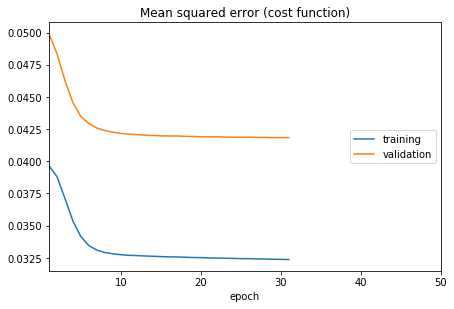

Mean squared error (cost function):
training   (min:    0.032, max:    0.040, cur:    0.032)
validation (min:    0.042, max:    0.050, cur:    0.042)
Epoch 00031: early stopping


In [55]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.15, random_state=42)

K.clear_session()
print("Building model...")
model = Sequential()
model.add(Dense(32, input_shape=(dims,),activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(output_var))
model.add(Activation('relu'))
model.compile(optimizer='sgd', loss='mean_squared_error')
model.summary()
fBestModel = 'best_model.h5' 
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=3, 
          batch_size=128, verbose=True, callbacks=[best_model, early_stop,])

In [57]:
test_X =  vect.transform(test_tokens)
test_y = model.predict(test_X)

In [58]:
submisson_df = pd.read_csv("../input/sample_submission.csv")
submisson_df['prediction'] = test_y
submisson_df['prediction'] = submisson_df['prediction'].apply(lambda x: "%.5f" % x if x > 0 else 0.0)

FileNotFoundError: File b'../input/sample_submission.csv' does not exist

In [ ]:
submisson_df.to_csv("submission.csv", index=False)